# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [4]:
ds_train = pd.read_csv("C:/Users/maico/Documents/Mestrado/dmeyf2023/datasets/competencia_02.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)


Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [5]:
ds_bajas = ds_train.query("clase_ternaria == 'BAJA+2'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [6]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'num_iterations': 670,
    'learning_rate': 0.0100738668153211,
    'feature_fraction': 0.413040235996875,
    'verbose': -100,
    'max_bin': 31,
    'min_data_in_leaf': 2858,
    'num_leaves:': 161,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Found `num_iterations` in params. Will use it instead of argument


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [7]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
0,foto_mes,1641
15,mcuenta_corriente,730
32,mprestamos_personales,714
152,Visa_mpagominimo,571
21,mcuentas_saldo,560
...,...,...
121,Master_madelantodolares,0
53,cpayroll2_trx,0
39,mplazo_fijo_pesos,0
52,mpayroll2,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [8]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [9]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.037481586935309764


,2102,7
internet,1.00,0.056023
cliente_edad,47.00,0.050518
mtransferencias_emitidas,0.00,0.021090
Visa_status,0.00,0.019866
cdescubierto_preacordado,1.00,0.016233
...,...,...
mtarjeta_visa_consumo,0.00,-0.226253
cpayroll_trx,0.00,-0.422514
mpayroll,0.00,-0.430314
mcaja_ahorro,3.33,-0.465952


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [10]:
shap_bajas.mean().abs().sort_values(ascending=False)


ctrx_quarter                   0.443825
mcaja_ahorro                   0.342809
mpayroll                       0.321795
foto_mes                       0.293458
cpayroll_trx                   0.281567
                                 ...   
cpayroll2_trx                  0.000000
mpayroll2                      0.000000
cseguro_auto                   0.000000
mplazo_fijo_pesos              0.000000
mcuenta_corriente_adicional    0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

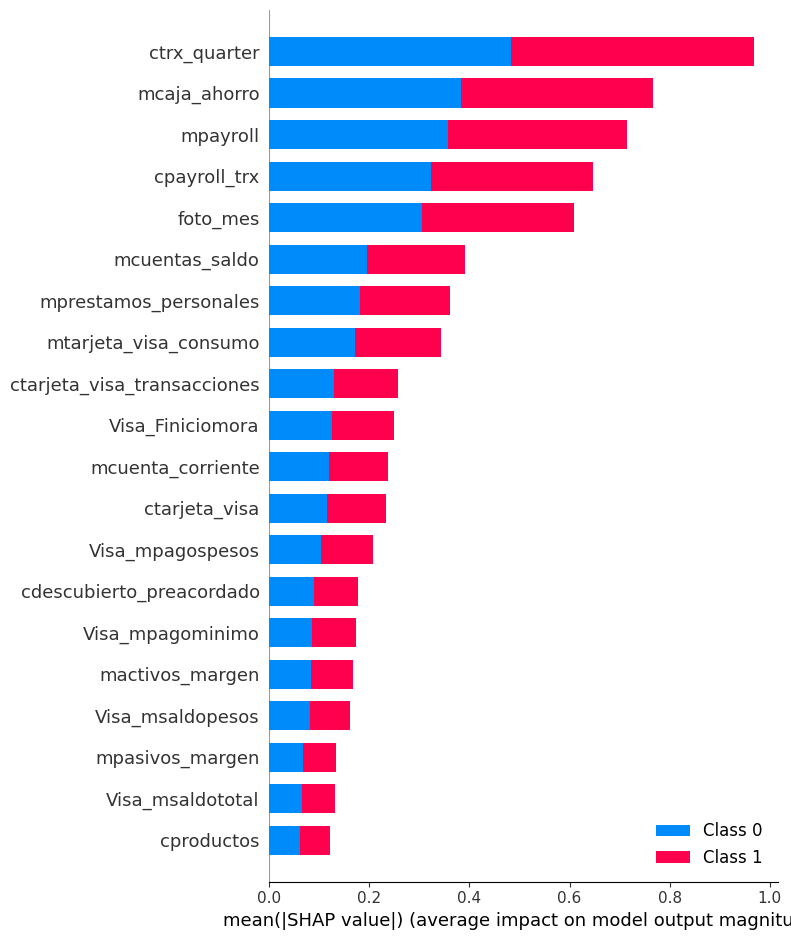

In [11]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

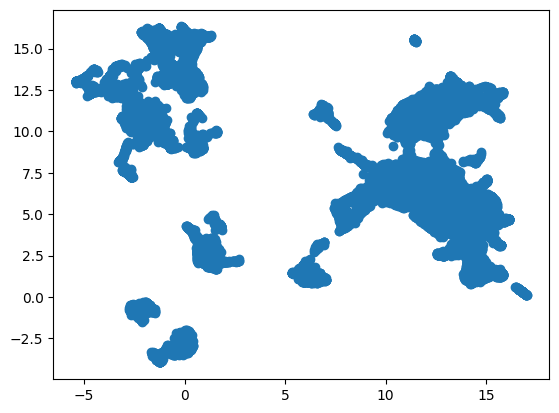

In [12]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([7.977e+03, 3.351e+03, 1.860e+03, 1.319e+03, 9.310e+02, 6.810e+02,
        5.370e+02, 4.550e+02, 3.570e+02, 2.450e+02, 1.880e+02, 1.340e+02,
        1.280e+02, 8.600e+01, 6.800e+01, 6.500e+01, 7.400e+01, 5.400e+01,
        3.700e+01, 3.100e+01, 3.600e+01, 3.600e+01, 2.600e+01, 3.700e+01,
        2.300e+01, 1.400e+01, 4.000e+00, 2.000e+00, 3.000e+00, 3.000e+00]),
 array([1.23650638e-04, 2.66867529e-02, 5.32498551e-02, 7.98129574e-02,
        1.06376060e-01, 1.32939162e-01, 1.59502264e-01, 1.86065366e-01,
        2.12628469e-01, 2.39191571e-01, 2.65754673e-01, 2.92317775e-01,
        3.18880878e-01, 3.45443980e-01, 3.72007082e-01, 3.98570184e-01,
        4.25133287e-01, 4.51696389e-01, 4.78259491e-01, 5.04822593e-01,
        5.31385696e-01, 5.57948798e-01, 5.84511900e-01, 6.11075002e-01,
        6.37638105e-01, 6.64201207e-01, 6.90764309e-01, 7.17327411e-01,
        7.43890514e-01, 7.70453616e-01, 7.97016718e-01]),
 <BarContainer object of 30 artists>)

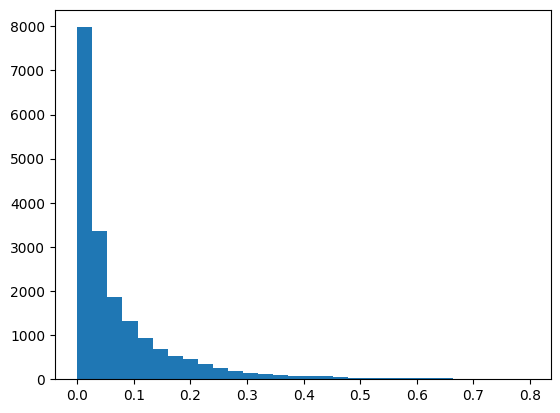

In [13]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

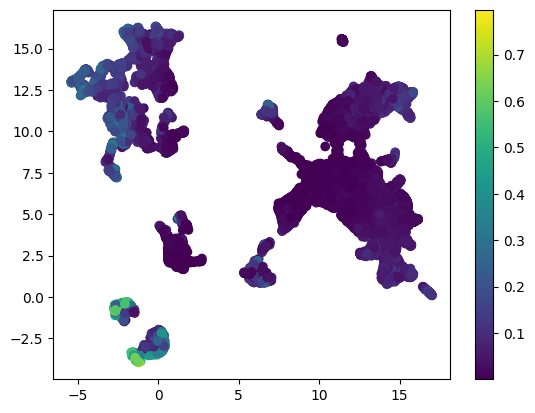

In [14]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


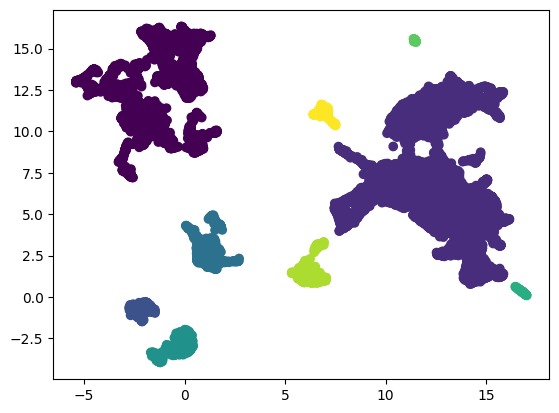

In [15]:
hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [16]:
shap_bajas[y.labels_ == 0].mean().sort_values(ascending=False)

chomebanking_transacciones           0.023679
ctarjeta_visa_debitos_automaticos    0.018413
mtransferencias_emitidas             0.013423
thomebanking                         0.008012
Visa_cadelantosefectivo              0.003592
                                       ...   
mpayroll                            -0.298245
cpayroll_trx                        -0.319464
ctarjeta_visa                       -0.367768
mcaja_ahorro                        -0.446076
ctrx_quarter                        -0.562337
Length: 153, dtype: float64

In [17]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

cdescubierto_preacordado             0.045931
chomebanking_transacciones           0.043741
ctarjeta_visa_debitos_automaticos    0.021572
mtransferencias_emitidas             0.021470
Visa_delinquency                     0.016465
                                       ...   
mcuentas_saldo                      -0.326268
mpayroll                            -0.350476
mcuenta_corriente                   -0.383991
mcaja_ahorro                        -0.583744
ctrx_quarter                        -0.990156
Length: 153, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

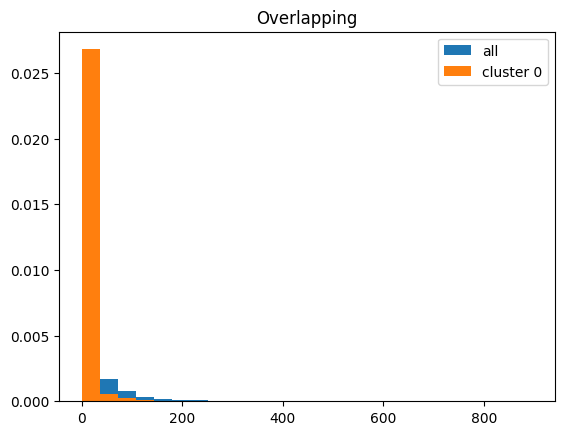

In [18]:
plt.hist(ds_bajas.loc[:]["chomebanking_transacciones"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 0]["chomebanking_transacciones"], label='cluster 0', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [19]:
np.unique(y.labels_).tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8]

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [20]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [21]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [22]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

In [ ]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [ ]:
sc = plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=p_bajas)
plt.colorbar(sc)
plt.show()

In [ ]:
hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y_rf = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y_rf.labels_)
plt.show()

In [ ]:
#listar os labels unicos
np.unique(y_rf.labels_).tolist()